In [ ]:
# Autoencoder for Anomaly Detection on MNIST
# Objective: Train an autoencoder to detect anomalies in handwritten digit images

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms as T
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import copy
import os

Using device: cpu


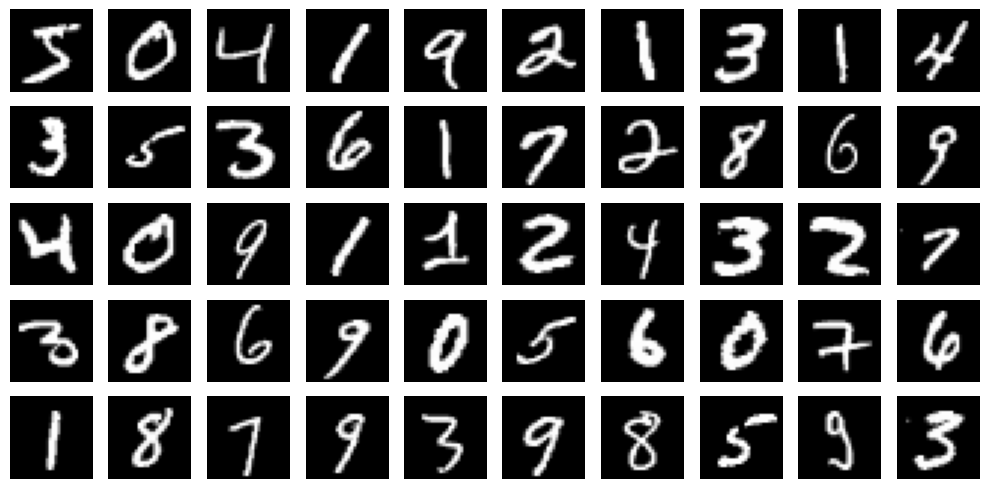

In [2]:
# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Create directories for saving figures
os.makedirs("plots", exist_ok=True)

# Load MNIST dataset
data_root = "./data"
train_dataset = MNIST(data_root, train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(data_root, train=False, download=True, transform=T.ToTensor())

# Data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Visualize dataset
def show_samples(dataset, save_path=None):
    h, w = 5, 10
    fig, ax = plt.subplots(h, w)
    fig.set_size_inches((w, h))
    ax = ax.ravel()
    for i in range(h * w):
        img, _ = dataset[i]
        ax[i].imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
        ax[i].axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Show example images
show_samples(train_dataset, save_path="plots/mnist_samples.png")

We can use a DataLoader together with the torchvision dataset which batches the data and can be used as an iterator.

In [3]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 1) Forward Pass (20P)

Please implement the forward pass of the network which receives a batch of image vectors $x \in \mathbb{R}^{N \times 1 \times 28 \times 28}$ and returns reconstructed images.

In [4]:
from torch import nn

class Autoencoder(nn.Module):

    def __init__(self, h: int = 32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 12000),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(12000, h),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(h, 12000),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(12000, 784),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        # Step 1: Flatten the input for the encoder
        # Input x has shape (N, 1, 28, 28)
        x = x.view(x.size(0), -1)  # Reshape to (N, 784)

        # Step 2: Pass through the encoder
        encoded = self.encoder(x)

        # Step 3: Pass through the decoder
        decoded = self.decoder(encoded)

        # Step 4: Reshape the output back to (N, 1, 28, 28)
        decoded = decoded.view(-1, 1, 28, 28)

        return decoded
        

# 2) Training Loop (20P)
The following method implements the training loop of the Autoencoder. Fill in the code for training a single iteration. The loss function to use should be clear from the lecture.

In [5]:
loss_fn = nn.MSELoss()

def train(loader, h=32, epochs=5):
    model = Autoencoder(h).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1:>2}")
        pbar = tqdm(loader)
        for batch, _ in pbar:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            prediction = model(batch)
            loss = loss_fn(prediction, batch)
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Loss: {loss.item():.4f}")

    return model

In [6]:
# Train the Autoencoder and receive respective parameters with hidden dimension 32
ae = train(train_loader, h=32, epochs=5)

Epoch  1


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/469 [00:00<?, ?it/s]

# 3) Reconstruction (20P)
After the training, we want to see how good the model reconstructs the encoded example with the decoder.

Plot a few samples of the test set and next to them the reconstruction of the previously trained autoencoder

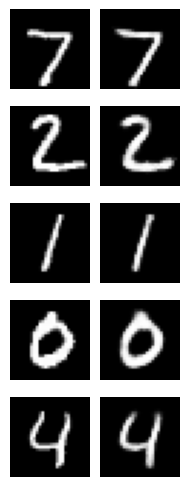

In [7]:
h, w = 5, 2
fig, ax = plt.subplots(h, w)
fig.set_size_inches((w, h))
ax = ax.ravel()

# Loop through a few examples from the test set
for i in range(h):
    img, _ = test_loader.dataset[i]
    img = img.unsqueeze(0)  # Add batch dimension, shape becomes: (1, 28, 28) -> (1, 1, 28, 28), since our model expects this format: N*C*H*W
    
    # Forward pass through the autoencoder
    pred = ae(img)
    
    # Reshape and prepare the reconstructed image
    pred = pred.squeeze(0).detach()  # Remove batch dimension, shape becomes: (1, 1, 28, 28) -> (1, 28, 28)
    
    # Plot the original image on the left
    ax[2 * i].imshow(img.squeeze(0).squeeze(0), cmap="gray")  # Original image, (1, 1, 28, 28) -> (28, 28)
    ax[2 * i].axis('off')
    
    # Plot the reconstructed image on the right
    ax[2 * i + 1].imshow(pred.squeeze(0), cmap="gray")  # Reconstructed image
    ax[2 * i + 1].axis('off')

# Display the results
plt.tight_layout()
plt.savefig("plots/reconstruction_examples.png", bbox_inches='tight')
plt.show()
plt.close()

We can see that we can still recover most of the digit details from the hidden representation.

# Anomaly Detection
Now we want to use an Autoencoder for anomaly detection. Given a set of normal data points, anomaly detection wants to assign a high anomaly score for samples that are in some way abnormal from the set of normal samples. In our example the normal samples will be all digits up until `threshold_class` (exclusive). All other samples are considered anomalies. You may play around with this parameter, for now we will fix it to 1, meaning we will only consider 0's.

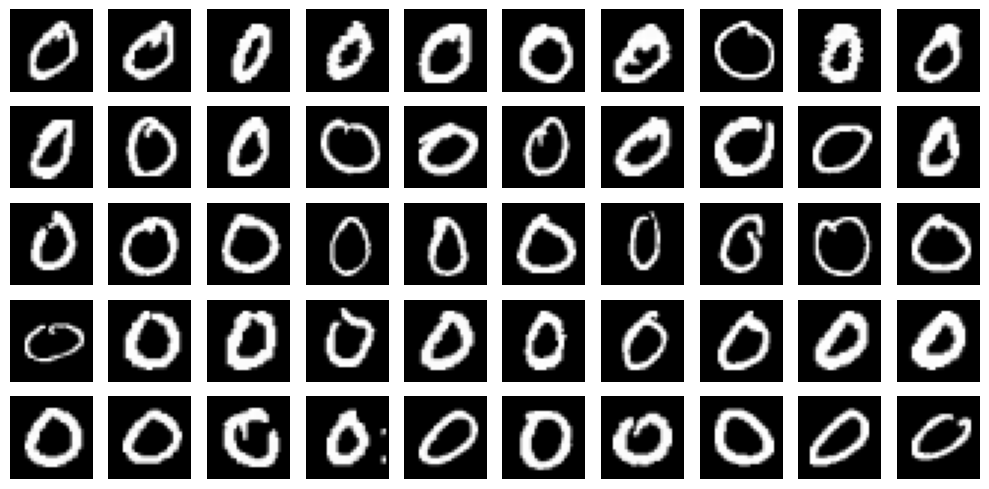

In [8]:
threshold_class = 1
threshold_class_train = Subset(dataset=copy.deepcopy(train_dataset), indices=np.where(train_dataset.targets < threshold_class)[0])
train_threshold_class_loader = DataLoader(threshold_class_train, batch_size=64, shuffle=True)
show_samples(threshold_class_train)

In [9]:
# We increase number of epochs because the dataset is now smaller.
anomaly_ae = train(train_threshold_class_loader, h=32, epochs=10)

Epoch  1


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  6


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  7


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  8


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch  9


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/93 [00:00<?, ?it/s]

# 4) Anomaly Score (20P)
Given now the trained autoencoder, we want to assign each sample an anomaly score. By using your knowledge from the lecture, implement the anomaly score for a batch of samples x, given its reconstruction from the autoencoder. The function should return an array that holds an anomaly score for each sample of the batch.

In [10]:
def anomaly_score(x, reconstruction):
    # Reconstruction error: Mean Squared Error (MSE) for each sample
    reconstruction_error = torch.mean((x - reconstruction) ** 2, dim=(1, 2, 3))
    
    # Convert to a NumPy array for compatibility with downstream functions
    return reconstruction_error.cpu().numpy()

### Evaluating 
For all the samples from the test set, we compute the anomaly score. Then, we want to check how good the anomaly score seperates the normal samples from the anomalies. For that purpose, the `roc_auc_score` can be used. A larger score indicates that the normal samples can be better seperated from the anomalies. We also plot a histogram with the anomaly scores to visualize the separation.

AUC: 0.9933846554142721
AUC might misrepresent performance on skewed class distributions, 
especially with highly imbalanced datasets. 
That’s why I would also check precision-recall curves depending on the use case.


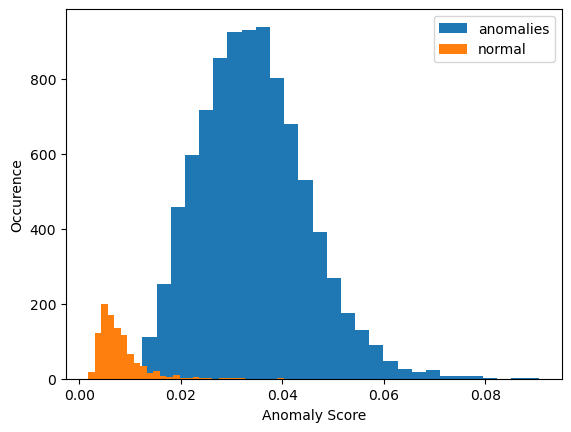

In [11]:
def compute_anomaly_scores(test_loader, ae):
    anomaly_scores = []
    labels = []
    for x, y in test_loader:
        reconstruction = ae(x).detach()
        batch_anomaly_scores = anomaly_score(x, reconstruction)
        # label 0 if sample is normal, otherwise 1
        batch_labels = (y >= threshold_class).numpy()
        anomaly_scores.append(batch_anomaly_scores)
        labels.append(batch_labels)
    anomaly_scores = np.concatenate(anomaly_scores)
    labels = np.concatenate(labels)
    return anomaly_scores, labels

test_loader = DataLoader(test_dataset, batch_size=64)
anomaly_scores, labels = compute_anomaly_scores(test_loader, anomaly_ae)
score = roc_auc_score(labels, anomaly_scores)

print('AUC:', score)
print("AUC might misrepresent performance on skewed class distributions, \n" \
"especially with highly imbalanced datasets. \n" \
"That’s why I would also check precision-recall curves depending on the use case.")
for name, label in [('anomalies', 1), ('normal', 0)]:
    plt.hist(anomaly_scores[labels == label], bins=30, label=name)
plt.ylabel('Occurence')
plt.xlabel('Anomaly Score')
plt.legend()
plt.savefig("plots/anomaly_score_histogram.png", bbox_inches='tight')
plt.show()
plt.close()

We can see that the zero digit (normal data) and all other digits are well separated with the anomaly score.

## Anomaly Heatmaps
One advantage of the autoencoder anomaly detection method is that we can use the reconstructions as an anomaly heatmap. These show which parts could not be reconstructed well from the model. The code below plots for selected samples the reconstruction and the anomaly heatmap.

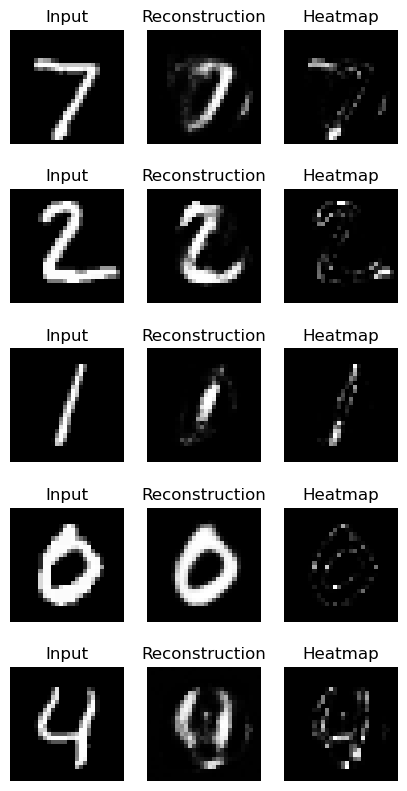

In [12]:
num_images = 5
test_batch = next(iter(test_loader))[0][:num_images]
reconstructions = anomaly_ae(test_batch).squeeze().detach()

fig, ax = plt.subplots(num_images, 3)
fig.set_size_inches(5, 10)
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0], cmap="gray")
    ax[i][0].set_title('Input')
    ax[i][1].imshow((reconstructions[i]), cmap="gray")
    ax[i][1].set_title('Reconstruction')
    ax[i][2].imshow((reconstructions[i] - test_batch[i][0])**2, cmap="gray")
    ax[i][2].set_title('Heatmap')
    for a in ax[i]:
        a.axis('off')
plt.savefig("plots/anomaly_heatmaps.png", bbox_inches='tight')
plt.show()
plt.close()

# Latent Space Visualization

Another interesting thing is the latent space of the autoencoder. Here we will visualize it by training a new autoencoder with a hidden dimension of 2, so that we can plot the latent representations of images using matplotlib.

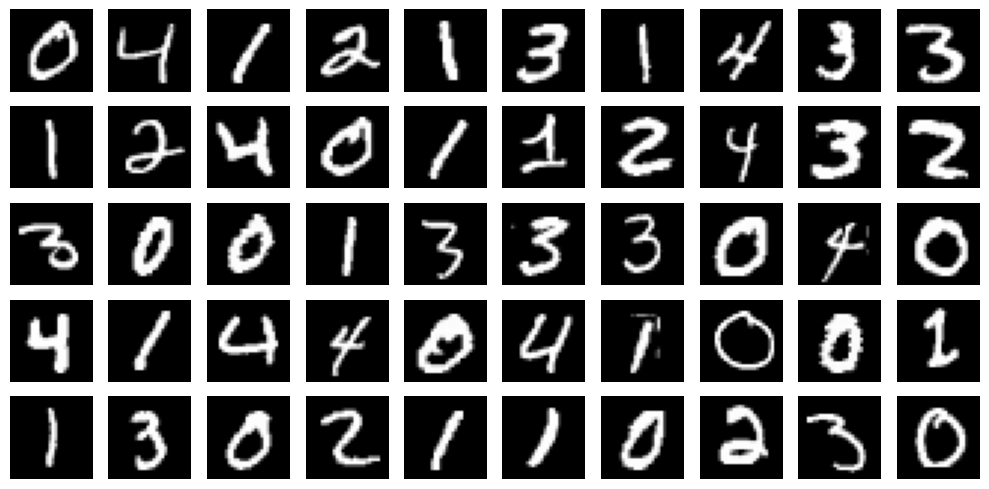

Epoch  1


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/479 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/479 [00:00<?, ?it/s]

In [13]:
threshold_class = 5
threshold_class_train = Subset(dataset=copy.deepcopy(train_dataset), indices=np.where(train_dataset.targets < threshold_class)[0])
train_threshold_class_loader = DataLoader(threshold_class_train, batch_size=64, shuffle=True)
show_samples(threshold_class_train)

small_ae = train(train_threshold_class_loader, h=2, epochs=5)

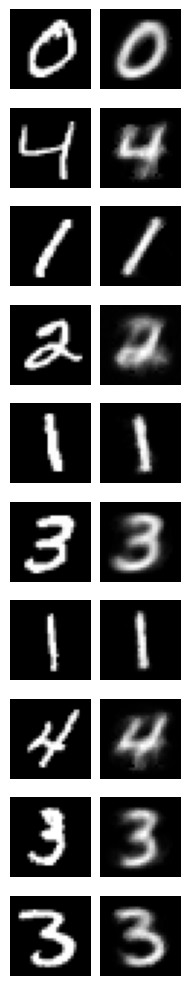

In [14]:
h, w = 10, 2
fig, ax = plt.subplots(h, w)
fig.set_size_inches((w, h))
ax = ax.ravel()

# Loop through a few examples from the test set
for i in range(h):
    img, _ = train_threshold_class_loader.dataset[i]
    img = img.unsqueeze(0)  # Add batch dimension, shape becomes: (1, 28, 28) -> (1, 1, 28, 28), since our model expects this format: N*C*H*W
    
    # Forward pass through the autoencoder
    pred = small_ae(img)
    
    # Reshape and prepare the reconstructed image
    pred = pred.squeeze(0).detach()  # Remove batch dimension, shape becomes: (1, 1, 28, 28) -> (1, 28, 28)
    
    # Plot the original image on the left
    ax[2 * i].imshow(img.squeeze(0).squeeze(0), cmap="gray")  # Original image, (1, 1, 28, 28) -> (28, 28)
    ax[2 * i].axis('off')
    
    # Plot the reconstructed image on the right
    ax[2 * i + 1].imshow(pred.squeeze(0), cmap="gray")  # Reconstructed image
    ax[2 * i + 1].axis('off')

# Display the results
plt.tight_layout()
plt.savefig("plots/latent_space_scatter.png", bbox_inches='tight')
plt.show()
plt.close()

# 5) Latent scatter plot (20P)

In this task you should plot the latent representations. You can use the labels as color information using `plt.scatter(c=labels)`.

In [15]:
# Number of samples to visualize
num_samples = 50  # Adjust this to control the number of samples
latent_representations = []
labels = []

# Loop through the data loader to get latent representations and labels
sample_count = 0
for x, y in train_threshold_class_loader:
    with torch.no_grad():  # No gradients needed during inference
        latent = small_ae.encoder(x.view(x.size(0), -1))

        latent_representations.append(latent)
        labels.append(y)
    
    sample_count += 1
    if sample_count >= num_samples:
        break  # Stop collecting samples once we reach the desired number
    
# Concatenate the selected samples into single tensors
latent_representations = torch.cat(latent_representations)[:num_samples].numpy()
labels = torch.cat(labels)[:num_samples].numpy()

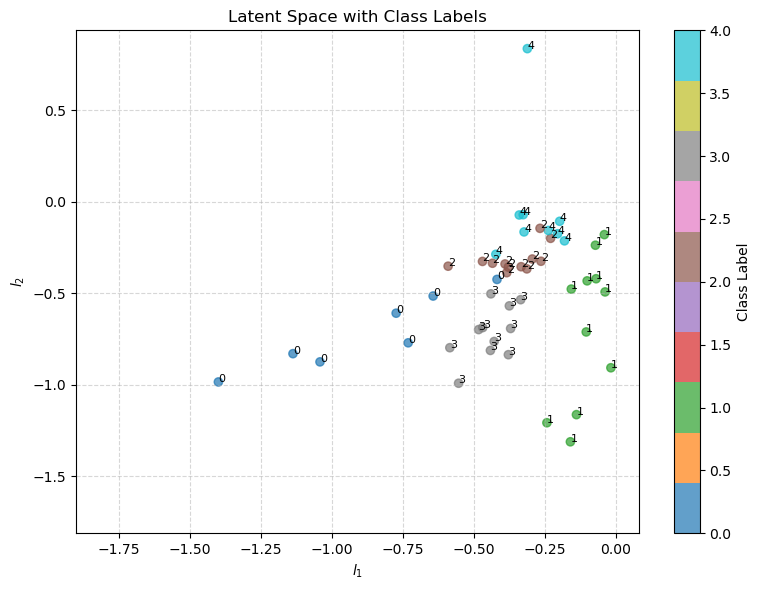

In [16]:
# Plot the latent space with reduced samples. threshold_class = 5!
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    latent_representations[:, 0], latent_representations[:, 1], c=labels, cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, label='Class Label')  # Add color bar to indicate class labels
plt.xlabel('$l_1$')  # Label for first latent dimension
plt.ylabel('$l_2$')  # Label for second latent dimension
plt.grid(True, linestyle='--', alpha=0.5)

# Explicitly adjust axis limits to ensure negative values are displayed
x_min, x_max = latent_representations[:, 0].min(), latent_representations[:, 0].max()
y_min, y_max = latent_representations[:, 1].min(), latent_representations[:, 1].max()
plt.xlim(x_min.min()-0.5, x_max.max()+0.1)
plt.ylim(y_min.min()-0.5, y_max.max()+0.1)

for i in range(len(latent_representations)):
    plt.text(latent_representations[i, 0],
             latent_representations[i, 1],
             str(labels[i]), fontsize=8)

plt.title("Latent Space with Class Labels")
plt.tight_layout()
plt.savefig("plots/latent_grid.png", bbox_inches='tight')
plt.show()
plt.close()